## Application of k-Means Clustering on the Customer dataset

K-means is a center-based clustering algorithm that works on the concept of centriod. We assume an initial `k` center points or centriods from the dataset. Other data points then start getting assigned to the closest centriod. The collection of points assigned to a cetriod form a cluster. Centriods are re-computed after this and are matched with the previously assigned values. If re-computed centriods are close enough or the same, then the process stops; otherwise, it continues.

#### Basic K-Means Algorithm

- Select `K` data points from the dataset as initial cluster centriods
- Compute distances from centriods for each other data points
- Assign a data point to the cluster having minimum distance
- Re-compute the centriods for all `K` clusters
- Re-compute `K` centriods and compare them with previous values
- Repeat from step 2 if centriod changes otherwise end.

### Objective

Study and visualize the clusters of sales data inclusive of all features

*Attribute Information:*
- 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
- 2) MILK: annual spending (m.u.) on milk products (Continuous);
- 3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
- 4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
- 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
- 6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
- 7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
- 8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)

*REGION Frequency*
- Lisbon 77
- Oporto 47
- Other Region 316
- Total 440

*CHANNEL Frequency*
- Horeca 298
- Retail 142
- Total 440



### Open the dataset

In [1]:
# import pandas for data manipulation
import os
import pandas as pd
import numpy as np

# import modules for visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# import modules for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
pd.options.mode.chained_assignment = None # to avoid SettingWithCopyWarning after scaling

# import modules for pipeline creation
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# import module for principal component analysis
from sklearn.decomposition import PCA

# import metrics for clustering algorithm
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
print('Project libraries has been successfully been imported!')

Project libraries has been successfully been imported!


In [2]:
# read the dataset
customer_data = pd.read_csv('C:/Users/hotty/Documents/Personal Projects/Machine Learning Projects/Machine-Learning-and-AI-Portfolio/data/raw/Wholesale customers data.csv')
customer_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


The dataset holds information about product wise sales across different channels and regions. From the data description, we can observe that `Channel` and `Region` are categorical variables while the rest are continuous. 

### Data Pre-processing

Here, we pre-process the dataset by converting the categorical variables to continuous using `OneHotEncoder` and applying `StandardScalar` to continuous variables only. 

In [4]:
# numerical and categorical features
categorical_cols = ['Channel', 'Region']  # categorical columns 
numeric_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']  # numerical columns

# create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

We can now determine the optimal `k` using the `Elbow method` or `Silhouette analysis`.

### Determining Optimal K using Elbow Method

In [5]:
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data)
customer_data_scaled

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

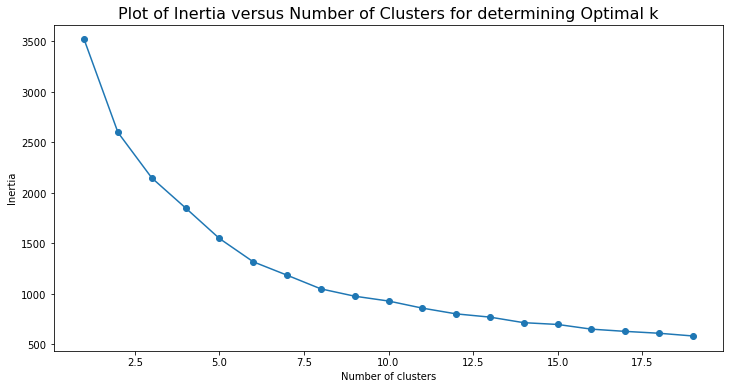

In [6]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(customer_data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
sse_df = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(sse_df['Cluster'], sse_df['SSE'], marker='o')
plt.title('Plot of Inertia versus Number of Clusters for determining Optimal k', fontsize=16)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

Looking at the above elbow curve, we can choose any number of clusters between 5 to 8. Let’s set the number of clusters as 5 and fit the model.

### Determine Optimal K with Silhouette analysis

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.5511475580221479
For n_clusters = 3 The average silhouette_score is : 0.497007227854376
For n_clusters = 4 The average silhouette_score is : 0.5040485181244349
For n_clusters = 5 The average silhouette_score is : 0.49292316331019265
For n_clusters = 6 The average silhouette_score is : 0.48808513972312256
For n_clusters = 7 The average silhouette_score is : 0.45515002386667625
For n_clusters = 8 The average silhouette_score is : 0.45317333880049815
For n_clusters = 9 The average silhouette_score is : 0.42181307548156916
For n_clusters = 10 The average silhouette_score is : 0.42859490353515795
For n_clusters = 11 The average silhouette_score is : 0.388035219078821
For n_clusters = 12 The average silhouette_score is : 0.39760655804983547
For n_clusters = 13 The average silhouette_score is : 0.40765882475198895
For n_clusters = 14 The average silhouette_score is : 0.39347849351900643
For n_clusters = 15 The average silhouette_score is 

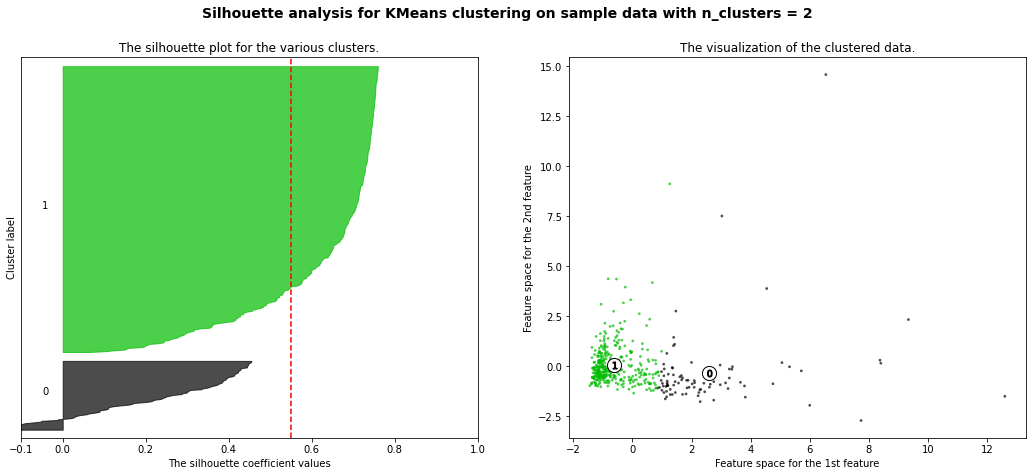

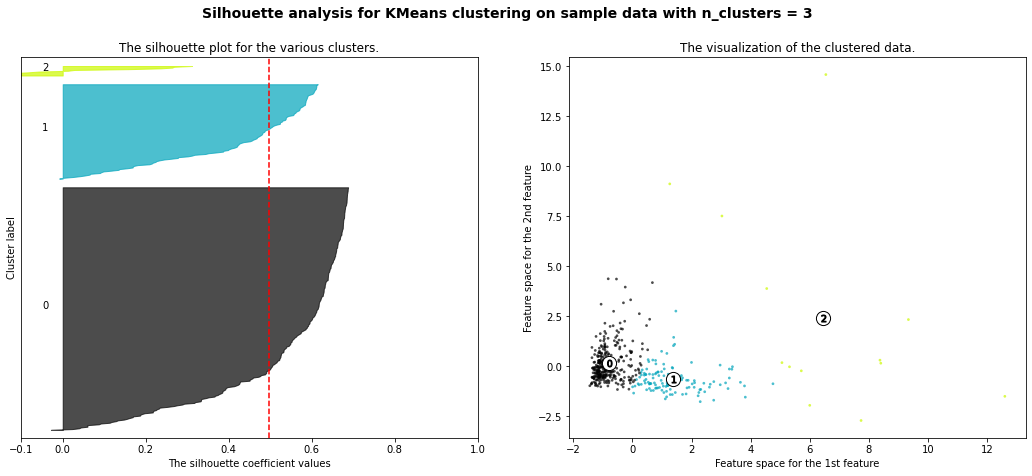

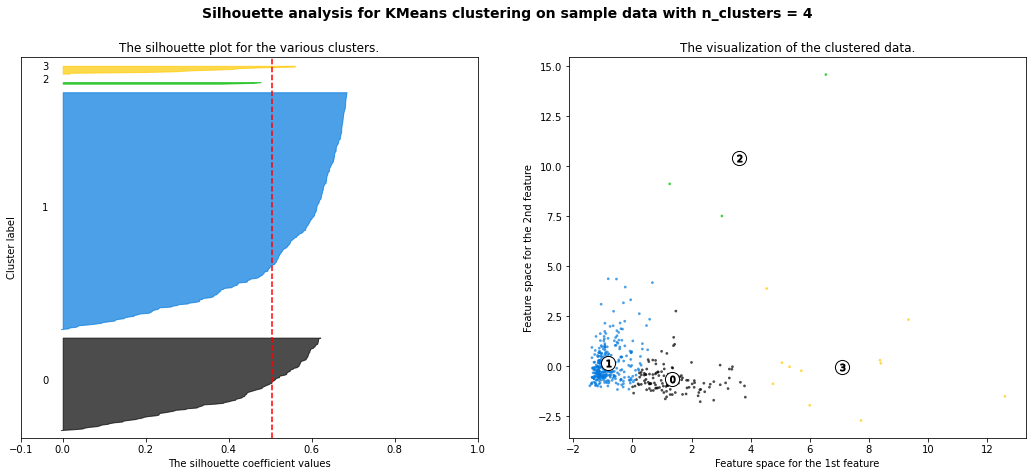

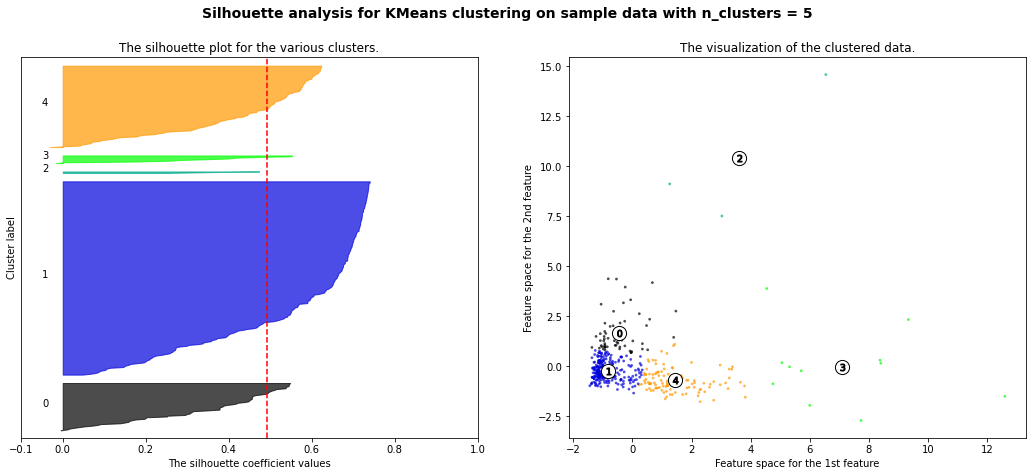

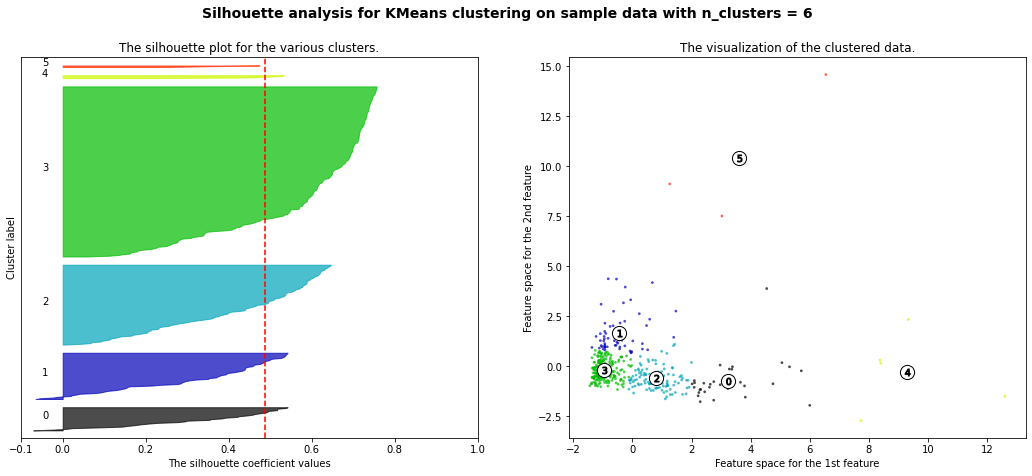

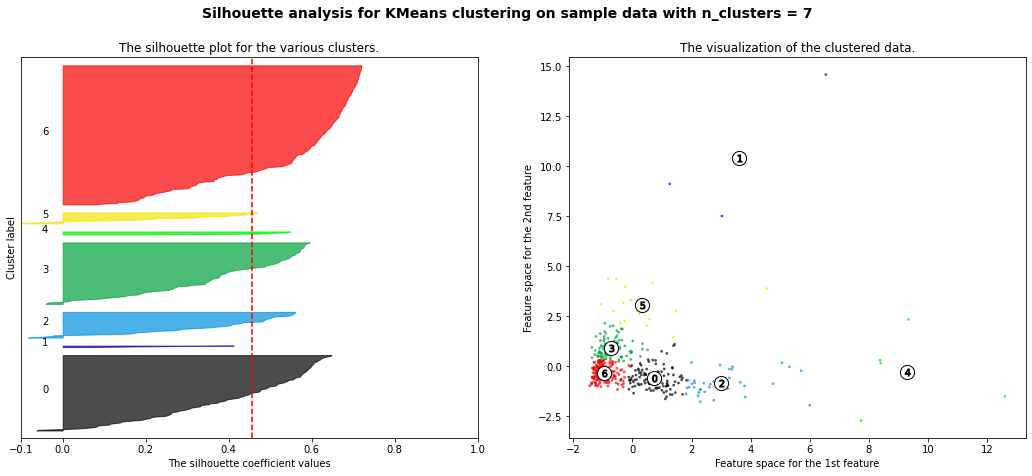

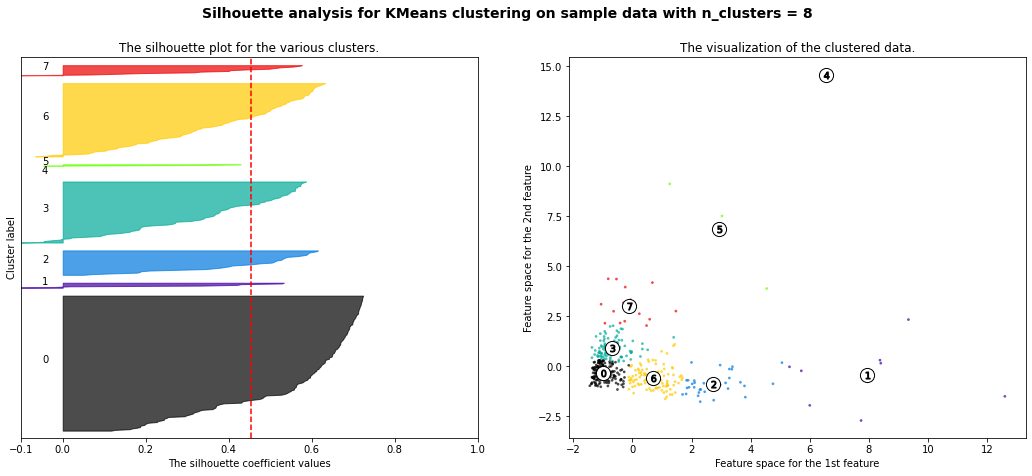

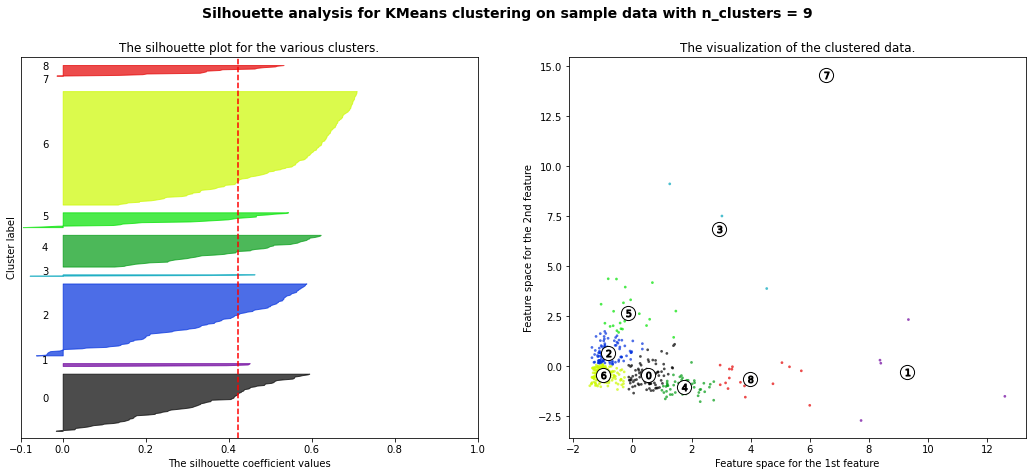

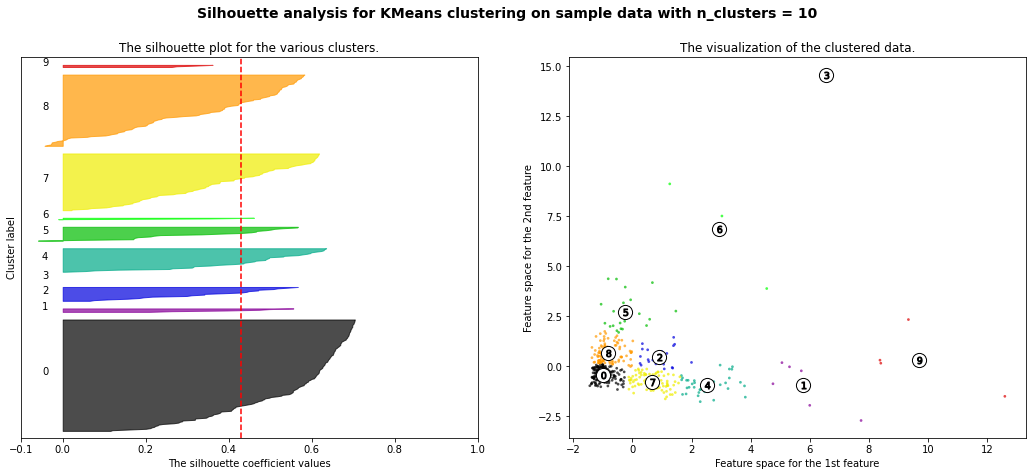

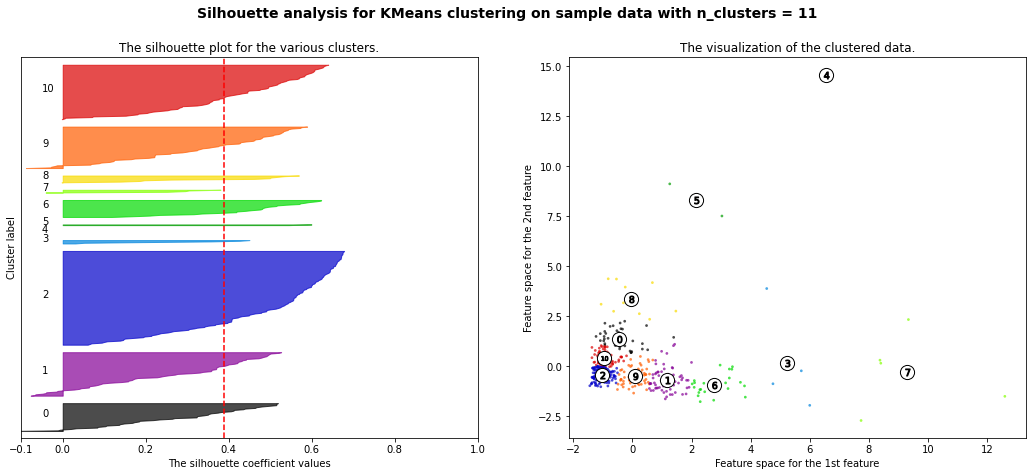

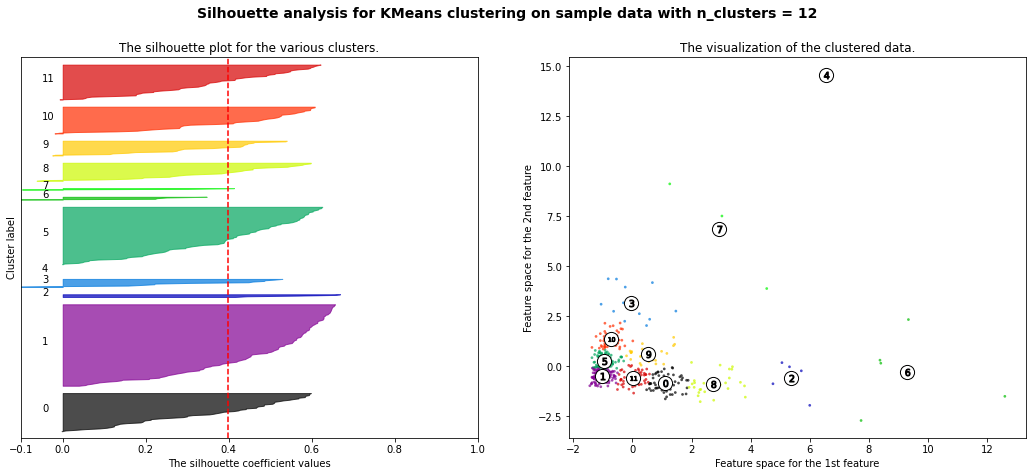

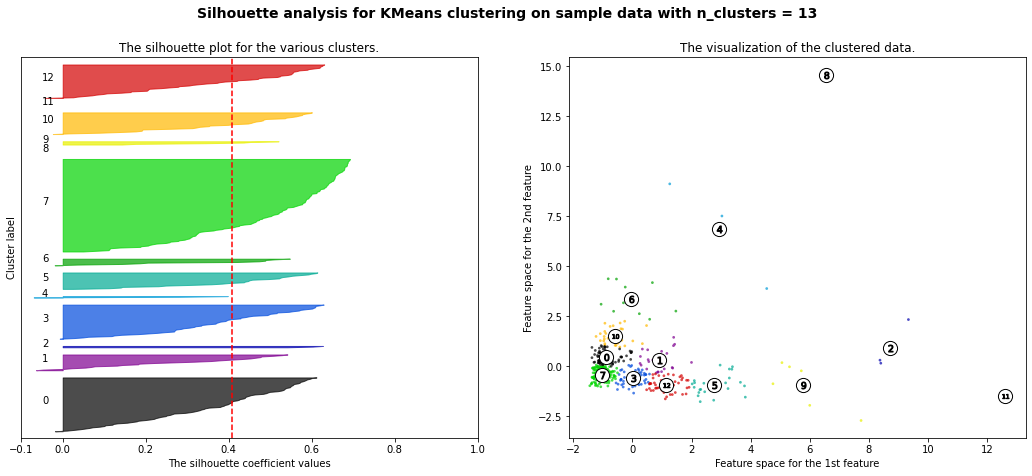

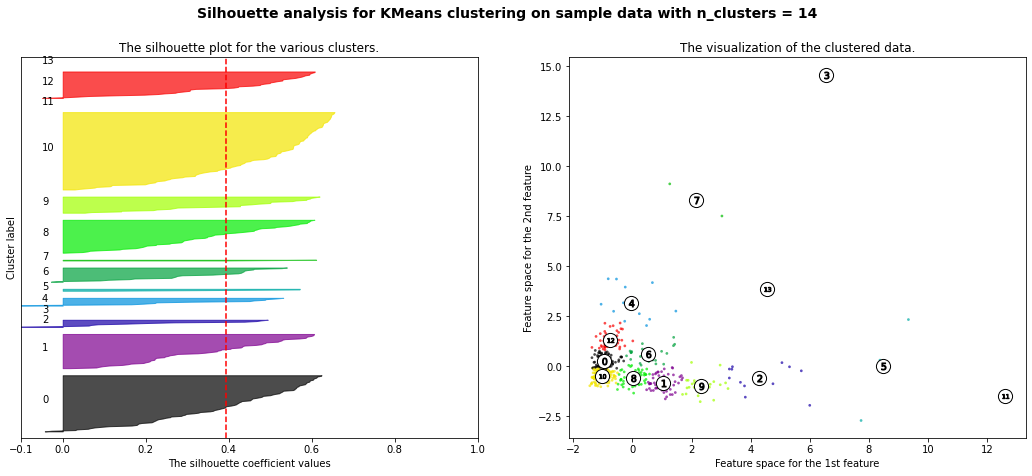

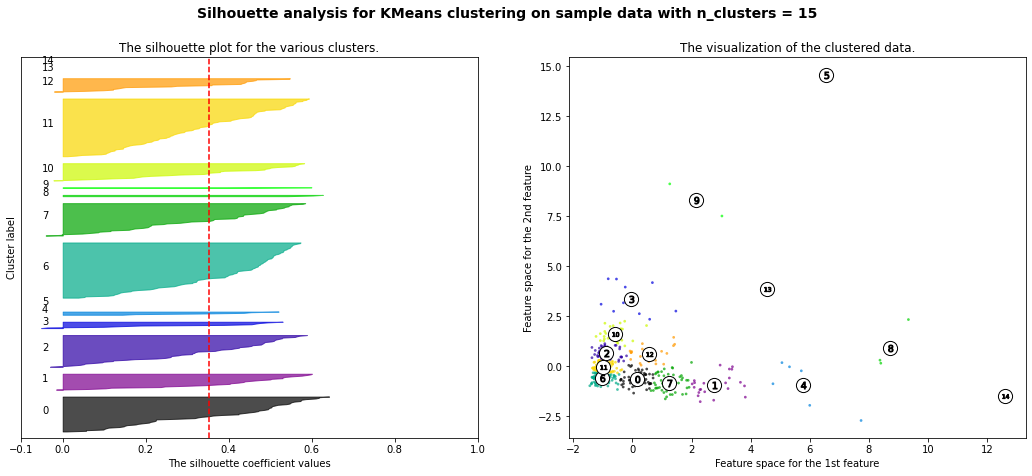

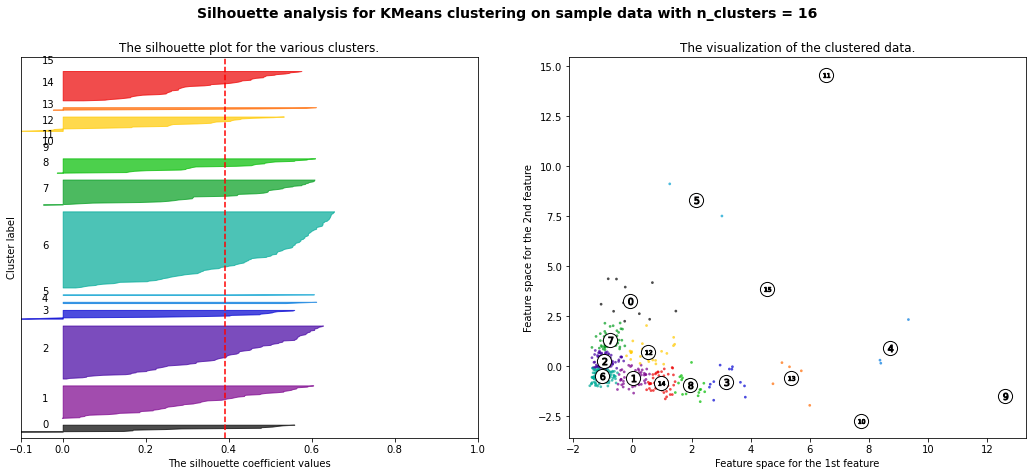

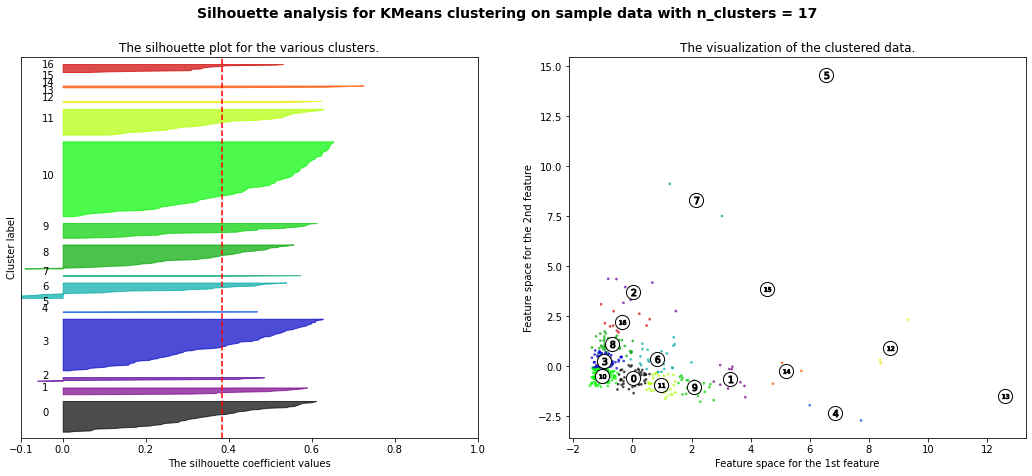

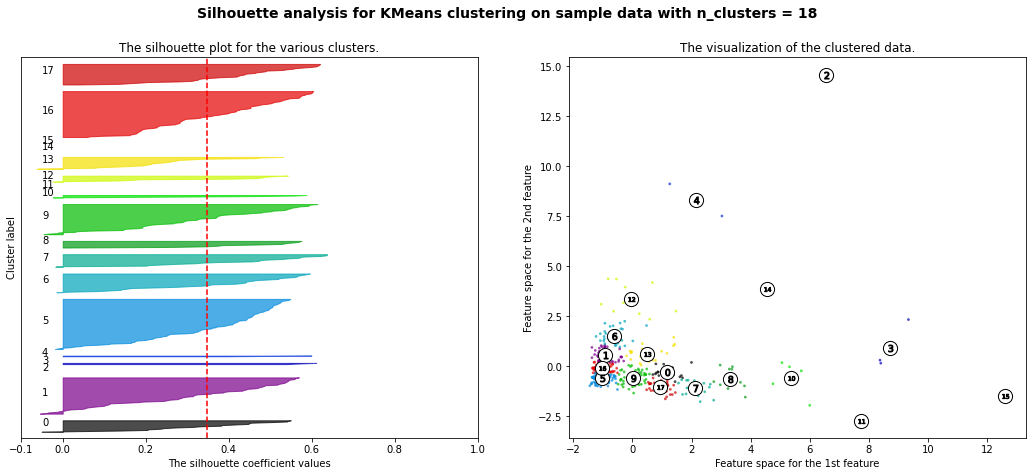

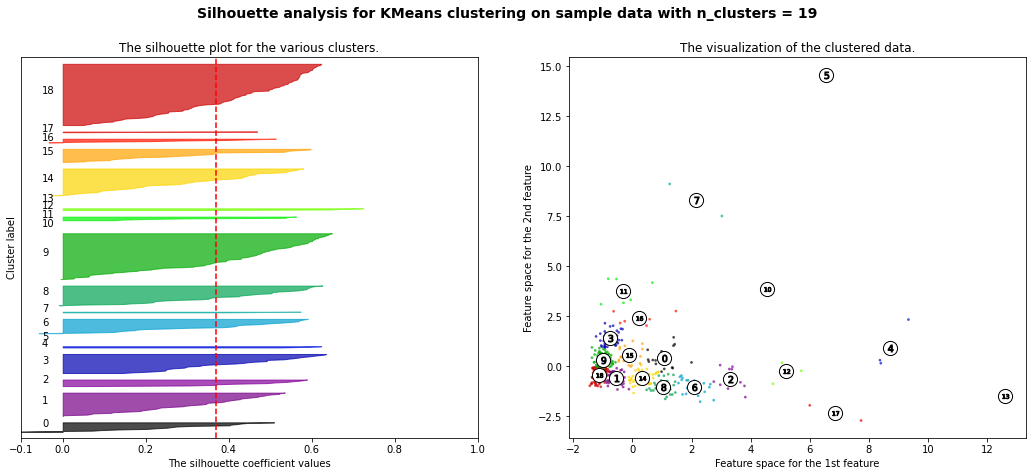

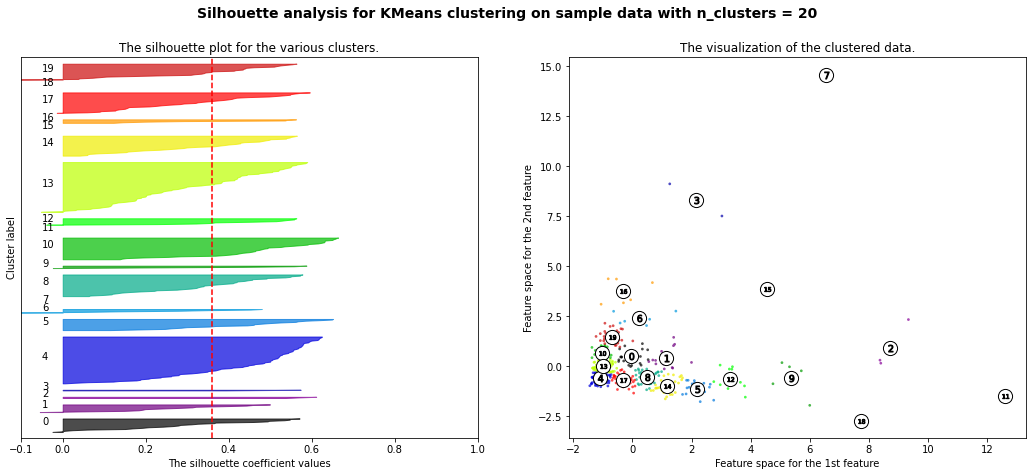

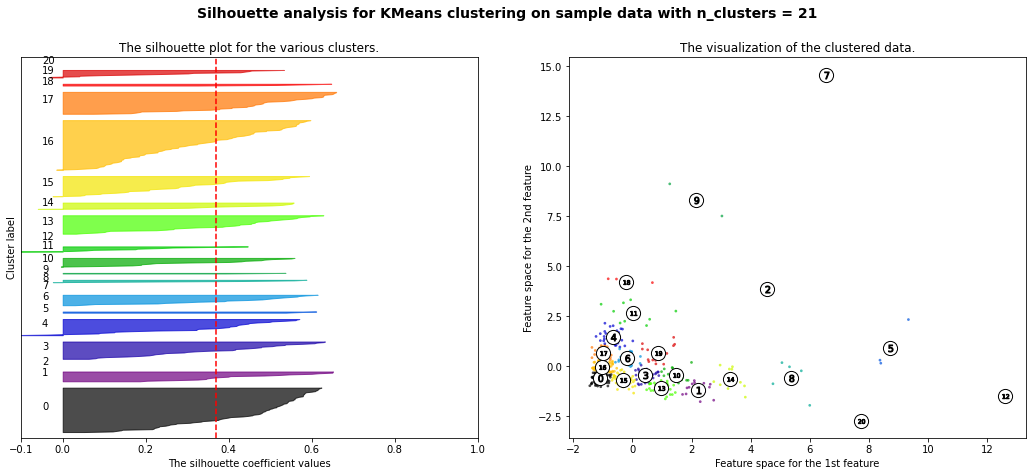

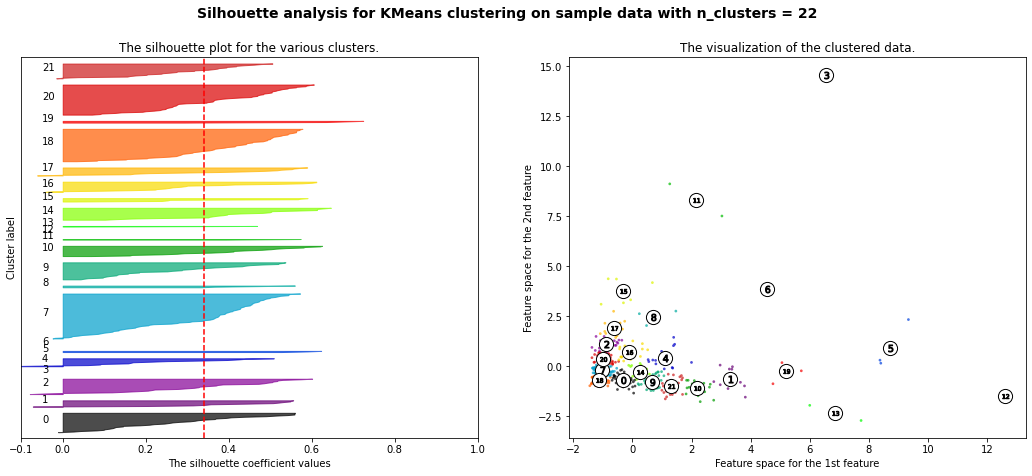

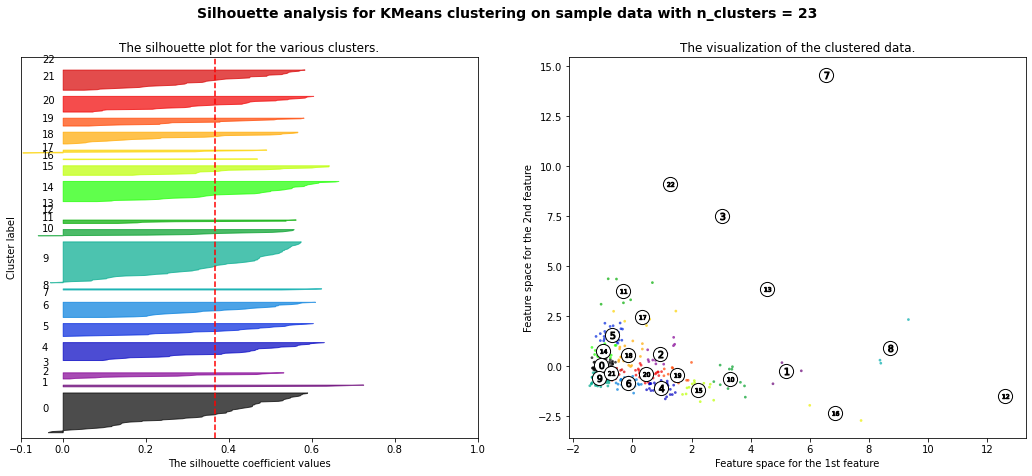

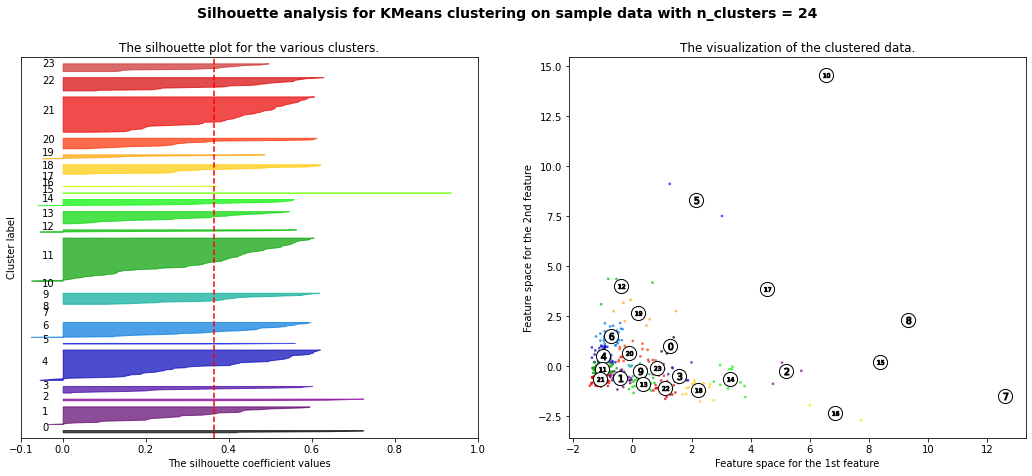

In [7]:
pca_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 2))
        ]
)

# create pca vectors - X
pca_vectors = pca_pipe.fit_transform(customer_data)
X = pca_vectors

range_n_clusters = np.arange(2, 25, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

The silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 5 is a good pick for the given data due to less fluctuations in the size of the silhouette plots.

### Visualization of clusters

- **Using any two variables and cluster indices**

We can visualize clusters using `Milk` and `Grocery` as variables. Even though while doing cluster computation, we considered all variables, but here we will try to visualize those cluster patterns with respect to any two variables and the same computed cluster indices.

We use the `preprocessor` instance and `KMeans` itself as pipeline stages. Set cluster size as 5 (by n_clusters parameter).

In [8]:
kmeans_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters = 5))
        ]
)

# fit the customer data
kmeans_pipe.fit(customer_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['Fresh', 'Milk', 'Grocery',
                                                   'Frozen', 'Detergents_Paper',
                                                   'Delicassen']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Channel', 'Region'])])),
                ('kmeans', KMeans(n_clusters=5))])

The `fit` function computes centriod distances and does the actual learning of the algorithm. The Kmeans algorithm assigns one cluster membership for each data record. The `predict` function will give us those details as cluster indices (0 to 4):

In [9]:
# predict cluster membership
kmeans_pipe.predict(customer_data)

array([0, 0, 0, 4, 1, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 4, 4, 4,
       1, 0, 0, 0, 4, 4, 0, 1, 4, 4, 4, 1, 4, 0, 1, 0, 0, 1, 1, 4, 0, 0,
       0, 0, 0, 3, 0, 0, 4, 4, 1, 0, 4, 4, 3, 0, 4, 4, 0, 3, 0, 0, 4, 3,
       4, 0, 4, 4, 1, 1, 4, 1, 0, 4, 4, 0, 4, 4, 4, 0, 0, 4, 0, 3, 3, 1,
       4, 1, 4, 4, 3, 1, 0, 4, 0, 4, 4, 4, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0,
       4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 1, 1, 0, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 0, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 0,
       1, 4, 4, 4, 4, 1, 0, 2, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 4, 1, 1, 0,
       4, 4, 0, 0, 1, 4, 4, 0, 4, 0, 4, 0, 4, 3, 4, 4, 0, 0, 0, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4,
       4, 4, 4, 0, 4, 4, 4, 4, 4, 3, 4, 1, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4,
       0, 0, 0, 4, 0, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 0, 4, 0, 1, 1, 1, 1,
       4, 4, 4, 1, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 0,

The `predict` function can be used for any unknown/new data instance to determine its cluster membership. Once a new data point is given, it computes Euclidean distances from all centriods of the cluster setup and assigns the data point to the cluster whose centriod is closest.

We can visualize the clusters using any two variables and cluster indices or using the first two principal components and cluster indices

In [10]:
# get cluster labels or indices
cluster_labels = kmeans_pipe.predict(customer_data)

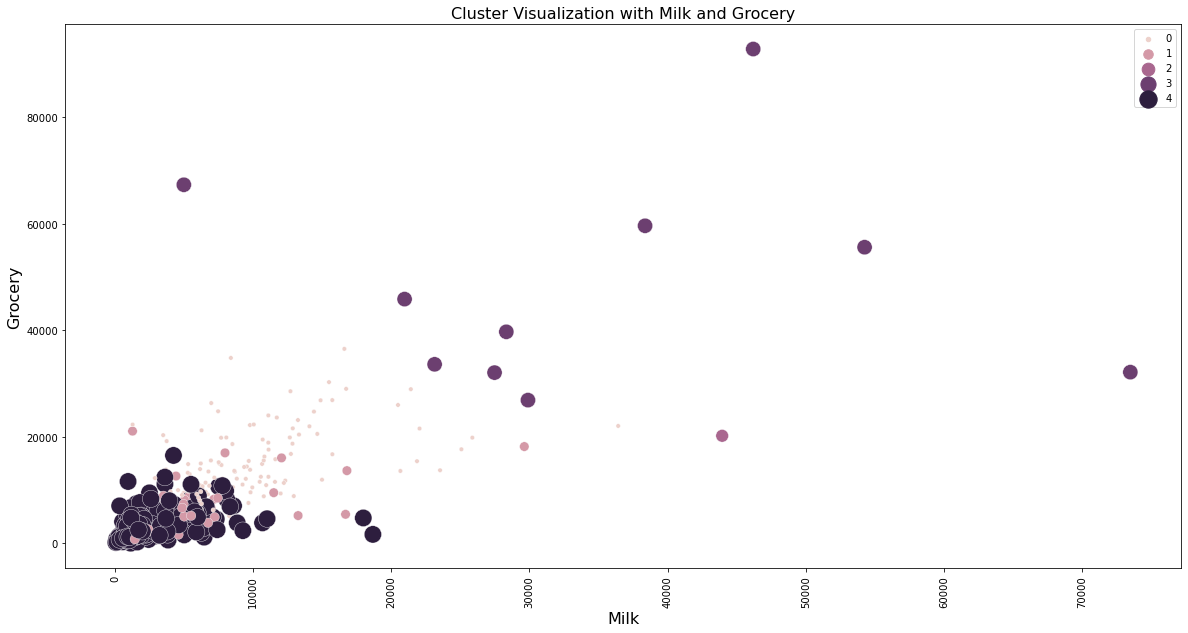

In [11]:
# cluster visualization using two variables and cluster indices
plt.figure(figsize=(20, 10))
sns.scatterplot(x ='Milk', y = 'Grocery', data = customer_data, hue = cluster_labels, size = cluster_labels, sizes = (20, 300))
plt.title('Cluster Visualization with Milk and Grocery', fontsize=16)
plt.ylabel('Grocery', fontsize=16)
plt.xlabel('Milk', fontsize=16)
plt.xticks(rotation='vertical');

We can see that there is a concentration of clusters (especially cluster index 3) in the range 0 - 20000 for `Grocery` and 0 - 10000 for `Milk`. So `Milk` and `Grocery` were sold more within these ranges. We can also get similar cluster patterns with respect to other remaining variable pairs. 

- **Using the first two principal components and cluster indices**

We can use principal component analysis to generate the two most import virtual dimensions and use those to re-run the KMeans algorithm. We use the pipeline generated before and PCA as an additional step.

In [12]:
pca_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 2))
        ]
)

# create pca vectors
pca_vectors = pca_pipe.fit_transform(customer_data)
pca_vectors

array([[ 4.56510987e-01, -4.15233235e-01],
       [ 6.90371107e-01, -4.13859584e-01],
       [ 9.86235647e-01,  7.46248727e-01],
       [-9.07106282e-01,  6.34782984e-01],
       [ 3.35755338e-01,  1.13006219e+00],
       [ 1.19396372e-01, -4.41716878e-01],
       [-3.80732985e-02, -6.87171852e-01],
       [ 4.02827403e-01, -3.49837686e-01],
       [-5.74674443e-01, -6.28149912e-01],
       [ 1.83178373e+00, -7.01265659e-01],
       [ 8.92241713e-01, -4.66822617e-01],
       [-6.27745123e-01, -4.47404670e-01],
       [ 1.16474959e+00,  6.41779558e-01],
       [ 1.07665725e+00, -1.32861412e-01],
       [ 1.05696458e+00,  1.03528532e-01],
       [-1.00284796e+00, -5.12217369e-01],
       [ 8.52259604e-01, -1.08773107e+00],
       [-4.68200766e-01,  2.39988299e-01],
       [ 5.30761279e-01,  3.30717861e-01],
       [-3.85225571e-01, -6.52005429e-01],
       [-6.50368939e-02, -1.53081557e-02],
       [-1.18027790e+00, -2.68564103e-01],
       [-4.17911924e-01,  2.16224823e+00],
       [ 4.

We apply KMeans on top of the `pca_vectors` to generate clusters.

In [13]:
# get pca cluster labels
cluster_labels_pca = KMeans(n_clusters = 5).fit_predict(pca_vectors)
cluster_labels_pca

array([1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       2, 4, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 1, 1,
       1, 1, 1, 4, 1, 1, 0, 0, 2, 1, 0, 0, 4, 1, 0, 0, 0, 4, 0, 1, 0, 4,
       0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 4, 4, 2,
       0, 2, 0, 2, 4, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1,
       0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       2, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 2, 1,
       0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 4, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

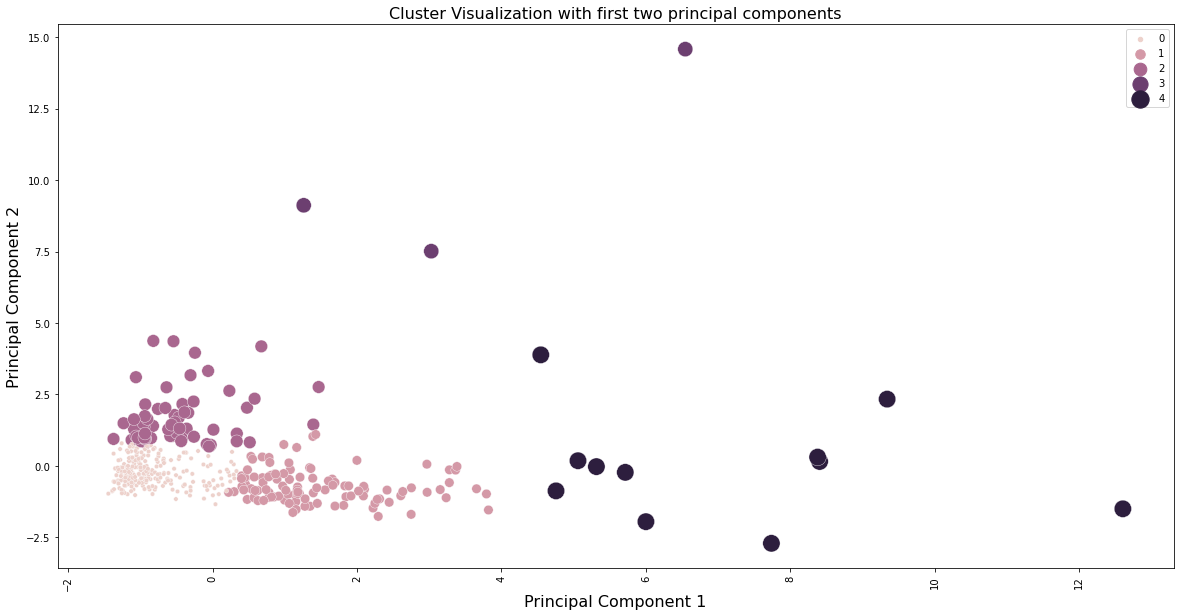

In [14]:
# cluster visualization using pca vectors and cluster indices
plt.figure(figsize=(20, 10))
sns.scatterplot(x = pca_vectors[:, 0], y = pca_vectors[:, 1], hue = cluster_labels_pca, size = cluster_labels_pca, sizes = (20, 300))
plt.title('Cluster Visualization with first two principal components', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

PCA does not specify the underlying physical attributes, and it may not be possible to infer which attribute is contributing significantly to it. From the cluster, we can see that there is high concentration of data points in value range around (-1.25) to (+1.25) for PC2, and (-2) to (0) for PC1. Clustering can reveal alot of information which are not available at first hand.

### Cluster Metric

#### Compute Silhouete coefficient

In [15]:
# compute sihouette score for cluster set up
silh_mean_score = silhouette_score(pca_vectors, cluster_labels)
silh_mean_score

0.47401643935836585

In [16]:
# compute silhouette score for each data point
silh_scores = silhouette_samples(pca_vectors, cluster_labels)
silh_scores

array([ 0.20020968,  0.35784043,  0.19725511,  0.3773978 ,  0.14867358,
       -0.15558762, -0.25542581,  0.13586649,  0.62129743,  0.58276871,
        0.45436559,  0.67959637,  0.2781819 ,  0.44409579,  0.38106921,
        0.75371227,  0.46395528,  0.55094849,  0.05511328,  0.52102971,
        0.38844713,  0.76019795,  0.46246041, -0.0240939 ,  0.18103451,
       -0.08146435,  0.74011325,  0.76362431,  0.4623838 ,  0.02377092,
        0.37731391,  0.73160971,  0.73917452,  0.22156069,  0.68085112,
        0.28127133,  0.2822115 ,  0.52126325,  0.57804568,  0.40603879,
        0.46061641,  0.40038297,  0.54065675,  0.53540633,  0.34435229,
        0.46636274,  0.57578999,  0.48576836,  0.38913284,  0.30044222,
        0.69610375,  0.55376846, -0.16466357,  0.49349426,  0.35494382,
        0.64933149,  0.0793032 ,  0.55313362,  0.76397641,  0.36058885,
       -0.06218734,  0.59685649,  0.00843803,  0.56615646,  0.76349234,
        0.36752578,  0.42525941,  0.40908709,  0.39578595,  0.75